In [1]:
import random
import cv2
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras import backend as K 
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

%matplotlib inline

# Hide Warnings
# pd.options.mode.chained_assignment = None

# Set Seeds
tf.random.set_seed(42)
seed = 42
np.random.seed(42) # numpy seed (also used by keras)
random.seed(42)

# Intelligent Data Analysis 2 Project: EuroSAT

## Problem Setting

### Dataset

EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification (Vol. 12, Number 7, pp. 2217–2226). Zenodo. https://doi.org/10.5281/zenodo.7711810

EuroSAT is a land use and land cover classification dataset. 

The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 LULC classes with a total of 27,000 labeled and geo-referenced images. The RGB version of the dataset includes the optical R, G and B frequency bands encoded as JPEG images. The multi-spectral version of the EuroSAT dataset includes all 13 Sentinel-2 bands in the original value range. This project uses the RGB version.

### Task

Train a neural network that predicts the right class label (y) of 10 available labels for a given input image of size 64 x 64 px with the Channels R, G and B (X).



### Learning Problem

Multiclass image classification (supervised)

## Explorative Data Analysis

In [2]:
ds, info = tfds.load('eurosat', split='all', data_dir='./data/eurosat', with_info=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

ds = tfds.as_numpy(ds)

images = []
labels = []

for image in ds:
    images.append(image['image'])
    labels.append(image['label'])
    
print(len(images))
print(len(labels))

images = np.array(images)
labels = np.array(labels)

<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
27000
27000


In [3]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [4]:
# Labels
print("Number of Labels:", info.features["label"].num_classes)
print("Label Names:", info.features["label"].names)
# print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
# print(info.features["label"].str2int('AnnualCrop'))

Number of Labels: 10
Label Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


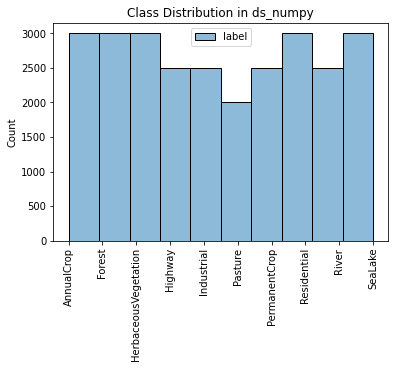

In [5]:
class_distribution = sns.histplot(ds, bins=10).set_title("Class Distribution in ds_numpy")
plt.xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)
plt.show()
# class_distribution.figure.savefig('report/figures/class_distribution.png', dpi=300, transparent=False, facecolor='white')

# Pasture - 2000
# Highway, Industrial, PermanentCrop, River - 2500
# AnnualCrop, Forest, HerbaceousVegetation, Residential, SeaLake - 3000

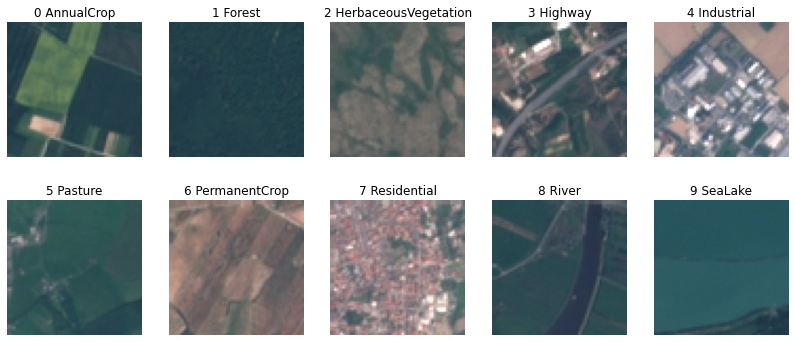

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

label_id = 0
for x in range(0, 2):
        for y in range(0, 5):            
            for image, label in zip(images, labels):
                if (label == label_id):
                        axs[x, y].imshow(image)
                        axs[x, y].set_title(str(label) + " " + info.features["label"].int2str(label))
                        axs[x, y].axis('off')
                        label_id += 1
                        break

## Preprocessing

In [7]:
# train_test_split shuffles the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=seed)
# X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=seed)

print(len(X_train))
print(len(X_test))
# print(len(X_validation))

21600
5400


In [8]:
# Data Augmentation of the training data set
X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    break
    # flip (cautious)
    # not implemented
    
    # rotate
    # img_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # img_180 = cv2.rotate(image, cv2.ROTATE_180)
    # img_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # X_train_augmented.append(img_90)
    # X_train_augmented.append(img_180)
    # X_train_augmented.append(img_270)
    
    # y_train_augmented.append(label)
    # y_train_augmented.append(label)
    # y_train_augmented.append(label)

X_train_complete = np.array(list(X_train) + X_train_augmented)
print(len(X_train_complete))

y_train_complete = np.array(list(y_train) + y_train_augmented)
print(len(y_train_complete))

21600
21600


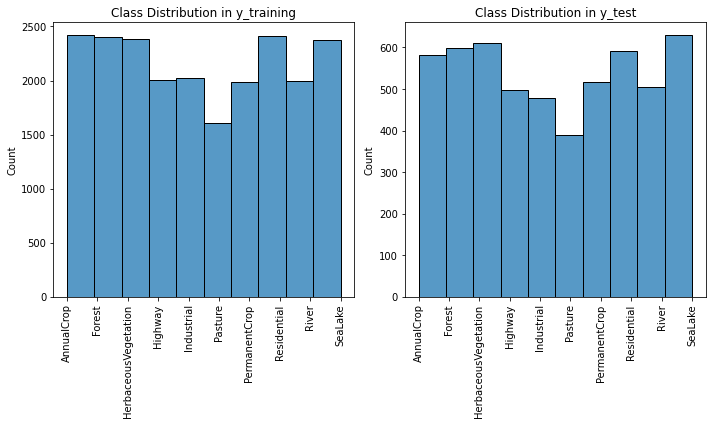

In [9]:
# Plot distribution of class labels in training and test set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.histplot(ax=axes[0], data=y_train_complete, bins=10)
axes[0].set_title("Class Distribution in y_training")
axes[0].set_xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)

sns.histplot(ax=axes[1], data=y_test, bins=10)
axes[1].set_title("Class Distribution in y_test")
axes[1].set_xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)

fig.tight_layout()

(x_train) min_val: 0 max_val: 255
(x_test) min_val: 0 max_val: 255


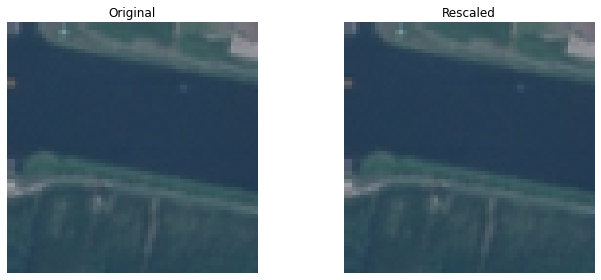

In [10]:
# normalize images
min_val = np.amin(X_train_complete)
max_val = np.amax(X_train_complete)
X_train_rescaled = (X_train_complete.astype(float) - min_val) / (max_val - min_val)
print("(x_train) min_val:", min_val, "max_val:", max_val)

min_val = np.amin(X_test)
max_val = np.amax(X_test)
X_test_rescaled = (X_test.astype(float) - min_val) / (max_val - min_val)
print("(x_test) min_val:", min_val, "max_val:", max_val)

# Print comparison of original and rescaled image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(X_train_complete[0])
axes[0].title.set_text('Original')
axes[0].axis('off')

axes[1].imshow(X_train_rescaled[0])
axes[1].title.set_text('Rescaled')
axes[1].axis('off')

fig.tight_layout()

In [13]:
X_test_rescaled.shape

(5400, 64, 64, 3)

In [14]:
nb_classes = 10
oneHotLabelTrain = np_utils.to_categorical(y_train_complete, nb_classes)
oneHotLabelTest  = np_utils.to_categorical(y_test,  nb_classes)
# oneHotLabelValidation  = np_utils.to_categorical(y_validation,  nb_classes)

## Method Application

### CNN based on exercise (baseline)

In [32]:
# simple CNN
def getBaselineCNNModel(
    input_shape = (64, 64, 3),
    nb_filters_one = 32,
    nb_filters_two = 64,
    nb_conv = 3,
    nb_pool = 2,
    dense_size = 128
):
    
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape)) # convolutional layer
    cnnModel.add(MaxPooling2D(pool_size=(nb_pool, nb_pool))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel

cnnModel = getCNNModel()
cnnModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3936384   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
batch_size = 64
numEpochs = 10

cnnModel = getBaselineCNNModel()
learnHistCNN = cnnModel.fit(X_train_rescaled,oneHotLabelTrain,
                               validation_data=(X_test_rescaled,oneHotLabelTest),
                               batch_size=batch_size,
                               epochs=numEpochs)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(learnHistCNN.history['loss'], label="loss")
axes[0].plot(learnHistCNN.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(learnHistCNN.history['accuracy'], label="accuracy")
axes[1].plot(learnHistCNN.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

In [ ]:
preds = cnnModel.predict(X_test_rescaled)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

### CNN (more advanced)

In [ ]:
# Advanced CNN
def getAdvancedCNNModel(
    input_shape = (64, 64, 3),
    nb_filters_one = 32,
    nb_filters_two = 64,
    nb_conv = 3,
    nb_pool = 2,
    dense_size = 128
):
    
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape)) # convolutional layer
    cnnModel.add(AvgPooling2D(pool_size=(nb_pool, nb_pool))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel

cnnModel = getCNNModel()
cnnModel.summary()

### ResNet (transfer learning)

In [15]:
# res = cv2.resize(X_test_rescaled[0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
# res.shape

def getResNet50():
    nb_classes = 10
    dense_size = 128

    base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (64,64,3), pooling='avg')

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(dense_size, activation='relu')(x)
    x = (Dropout(0.5))(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    head_model = Model(inputs = base_model.input, outputs = predictions)

    head_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return head_model

In [16]:
resnetmodel = getResNet50()
# resnetmodel.summary()

In [18]:
batch_size = 32
numEpochs = 4

history = resnetmodel.fit(X_train_complete, oneHotLabelTrain, batch_size=batch_size, epochs=numEpochs, 
                         validation_data=(X_test, oneHotLabelTest))

Epoch 1/4
675/675 [==============================] - 15s 23ms/step - loss: 0.5712 - accuracy: 0.8135 - val_loss: 0.3236 - val_accuracy: 0.8913
Epoch 2/4
675/675 [==============================] - 13s 20ms/step - loss: 0.3898 - accuracy: 0.8706 - val_loss: 0.2874 - val_accuracy: 0.9065
Epoch 3/4
675/675 [==============================] - 15s 22ms/step - loss: 0.3268 - accuracy: 0.8907 - val_loss: 0.2569 - val_accuracy: 0.9156
Epoch 4/4
675/675 [==============================] - 13s 19ms/step - loss: 0.2871 - accuracy: 0.9037 - val_loss: 0.2416 - val_accuracy: 0.9198


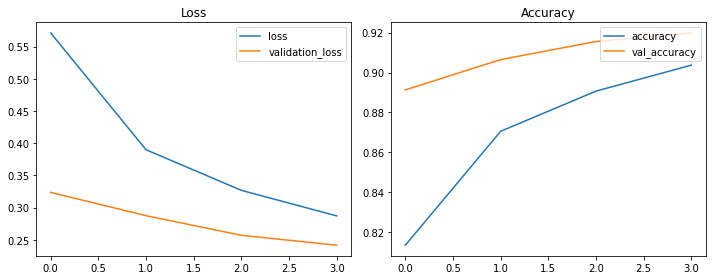

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(history.history['loss'], label="loss")
axes[0].plot(history.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(history.history['accuracy'], label="accuracy")
axes[1].plot(history.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

169/169 [==============================] - 4s 14ms/step


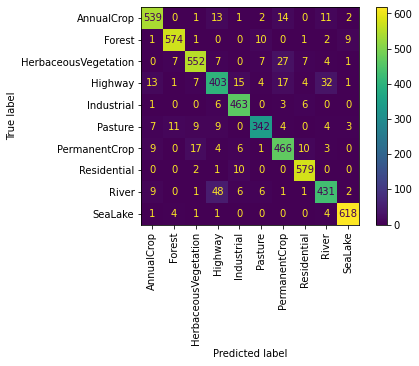

In [20]:
preds = resnetmodel.predict(X_test)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')


## Experiments

In [ ]:
batch_size = 32
numEpochs = 1

# simple CNN
# def getCNNModel(
#    input_shape = (64, 64, 3),
#    nb_filters_one = 32,
#    nb_filters_two = 64,
#    nb_conv = 3,
#    nb_pool = 2,
#    dense_size = 128
#)

params = []
val_accuracy = []

# for nb_conv in [3, 5, 7]:
#    for 


cnnModel = getCNNModel()
learnHistCNN = cnnModel.fit(X_train_complete,oneHotLabelTrain,
                               validation_data=(X_test,oneHotLabelTest),
                               batch_size=batch_size,
                               epochs=numEpochs)



In [ ]:
import keras_tuner as kt
from tensorflow import keras

tuner = kt.RandomSearch(
    getCNNModel,
    objective='val_loss',
    max_trials=10,
    seed=42
    )

tuner.search(X_train_rescaled, oneHotLabelTrain, epochs=54, validation_data=(X_test_rescaled, oneHotLabelTest))
best_model = tuner.get_best_models()[0]

In [ ]:
!pip install scikeras[tensorflow]

from sklearn.model_selection import RandomizedSearchCV

numEpochs = 4
n_iter = 4

keras_regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(getCNNModel)

# Hyperparameter Tuning wiht RandomSearch
params_random = {
    'nb_filters_one':[32],
    'nb_filters_two':[64],
    'nb_conv':[3, 5, 7],
    'nb_pool':[2],
    'dense_size':[128]
}

#params_random = {
#    'learning_rate':[0.0001, 0.001, 0.01], 
#    'momentum':[0.9, 0.99, 0.999],
#    'decay':[0.1, 0.01, 0.001, 0.0001], 
#    'dense_neurons':[200, 500],# 1000, 2000],
#    'n_filters':[16, 32, 64],
#    'first_kernel_size':[(3,3), (5,5), (7,7)]
#}

random_search = RandomizedSearchCV(keras_regressor, params_random, n_iter=n_iter)
random_search.fit(X_train_rescaled, oneHotLabelTrain, epochs=numEpochs, validation_data=(X_test_rescaled, oneHotLabelTest))
     
# Visualization of Randomized Search Results

print("Best sklearn-Score: ", random_search.best_score_)
     

print("Best Parameters: ", random_search.best_params_)
     

print("All results: ", random_search.cv_results_)
     

best_model = random_search.best_estimator_
     


In [ ]:
# hyperparameter tuning
# - Evaluation (Comparison of Models)

# for hyperparameter tuning
# https://github.com/into-ai/deeplearning2020/blob/master/woche4/notebooks/hyperparameter-optimization/hyperparameter-optimization.ipynb

## Conclusions

In [ ]:
# results + interpretation

# Comparing Loss and Accuracy of all models

# Future Tests: Vision Transformers (see Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929)
# Autoencoder also possible but not the best option
# - Vision Transformers https://keras.io/examples/vision/image_classification_with_vision_transformer/